In [1]:
import tensorflow as tf
import numpy as np

\begin{align}
y_1 = 2x_1^2 + 3x_2^2 -7x_3^2 -5x_1 + 11x_2 + 2x_3 + 3
\end{align}


\begin{align}
y_2 = 13x_1^2 - 11x_2^2 +7x_3^2 +2x_1 + 19x_2 - 13x_3 + 5
\end{align}

In [2]:
def generate_data(low = 0.0, high = 1.0, n=100, d=3):
    np.random.seed(73)
    return np.random.uniform(low, high, (n,d))

def quadratic_func(x, sq_coef, li_coef, bias):
    """Outputs a quadratic function with n variables  
    (based on dimension of ndarray and value of coefficients passed). 
    The number of dimensions and the number of coefficients should match"""
    sq_x = np.square(x)
    return sq_x @ sq_coef.T + x @ li_coef.T + bias
    
x = generate_data(-1.0,1.0,300, 3)

y1 = quadratic_func(x, np.array([[2,3,-7]]), np.array([[-5,11,2]]), 3)
y2 = quadratic_func(x, np.array([[13,-11,7]]), np.array([[2,19,-13]]), 5)

In [3]:
def plot_4d(x1,x2,x3,y_true,y_pred=None):
    %matplotlib inline
    %matplotlib notebook

    from matplotlib import cm
    from matplotlib import colors
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = 17, 10
    ax = plt.axes(projection='3d')
    
    max_y = np.max(y_true)
    min_y = np.min(y_true)
    
    if y_pred is not None:
        mx_pred = np.max(y_pred)
        mn_pred = np.min(y_pred)
        if mx_pred > max_y:
            max_y = mx_pred
        if mn_pred < min_y:
            min_y = mn_pred
    
    cmap = cm.get_cmap('seismic')
    norm = colors.Normalize(vmin=min_y,vmax=max_y)
    print(f'max : {max_y}  min : {min_y}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    sc1 = ax.scatter(x1, x2, x3,s=np.square(y_true[:,0] + 2),c=y_true[:,0] ,norm=norm, cmap=cmap)
    cb1 = plt.colorbar(sc1)
    cb1.set_label('y_true')
    if y_pred is not None:
        cmap2 = cm.get_cmap('PRGn')
        sc2 = ax.scatter(x1, x2, x3,s=np.square(y_pred[:,0] + 2),c=y_pred[:,0] ,norm=norm, cmap=cmap2)
        cb2 = plt.colorbar(sc2)
        cb2.set_label('y_pred')
#     sc = ax.scatter(x[:,0], x[:,1], x[:,2],s=np.square(y1[:,0] + 2),c=y1[:,0] ,norm=norm, cmap=cmap)
    plt.xlabel='x1'
    plt.ylabel='x2'
    plt.zlabel='x3'

<IPython.core.display.Javascript object>


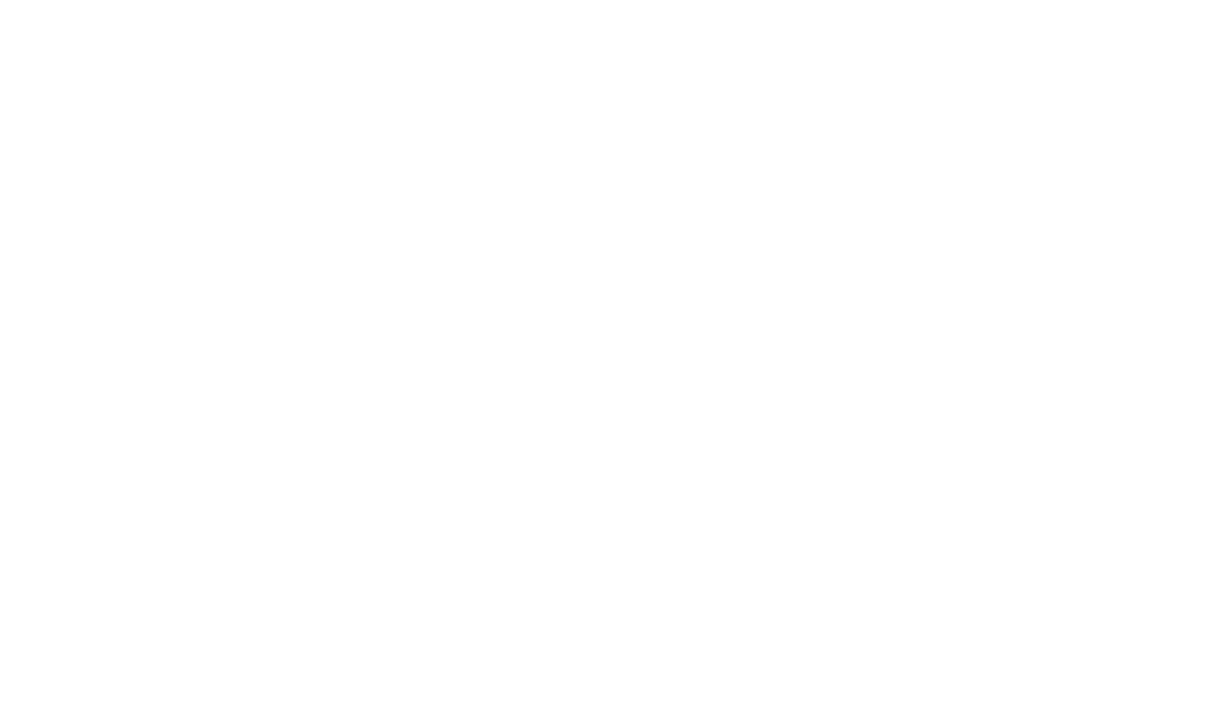

max : 20.284099794015997  min : -13.5285978007839


In [4]:
plot_4d(x[:,0], x[:,1], x[:,2], y1)

<IPython.core.display.Javascript object>


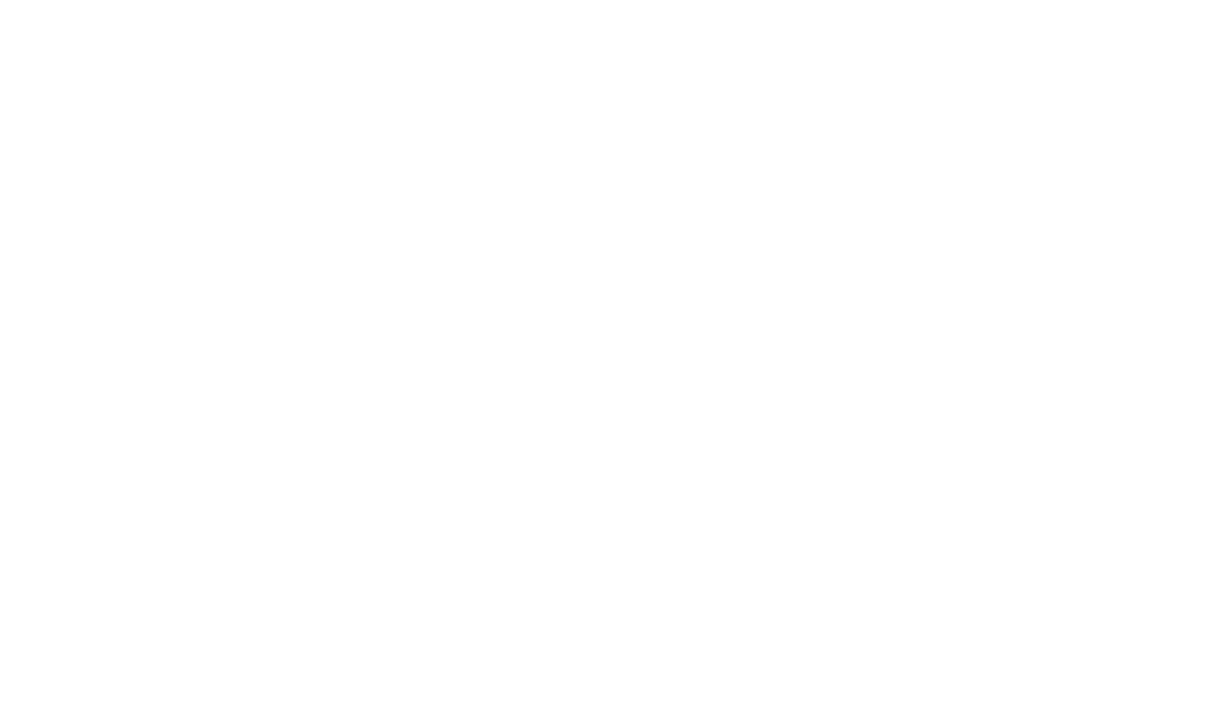

max : 42.6099130903702  min : -27.935697967500786


In [5]:
plot_4d(x[:,0], x[:,1], x[:,2], y2)

In [6]:
y_true = np.concatenate((y1,y2), axis=1)
print(x.shape)
print(y_true.shape)

(300, 3)
(300, 2)


## Using tensorflow tensors

In [7]:
x_tensor = tf.convert_to_tensor(x, np.float32)
y_true_tensor = tf.convert_to_tensor(y_true, np.float32)

In [38]:
class Linear:
    
    def __init__(self, input_dim, num_neurons):
        self.weights = tf.random.normal((input_dim, num_neurons)) * np.sqrt(2/ input_dim)
        self.bias = tf.zeros(1)
        
    def __call__(self, x):
        self.x = x
        output = x @ self.weights + self.bias
        return output
    
    def backprop_gradient(self, gradient):
        # Here we are computing the gradient with which we need to adjust the weight and bias of this layer
        # using the gradient from the layer after this, and we also compute the x-gradient (the gradient with which
        # the previous layer's output needs to adjust which will get returned)
        
        # y = wx + b
        # x-gradient    dy/dx = w
        # w-gradient    dy/dw = x
        # bias gradient dy/db = 1
        #(300, 3)(3, 3)(300, 1)
        self.w_gradient = tf.transpose(self.x) @ gradient
        self.x_gradient = gradient @ tf.transpose(self.weights)
        self.bias_gradient = tf.math.reduce_sum(gradient)
        return self.x_gradient
    
    def update(self, lr):
        # Updating weights and bias value calculated in backprop function
        self.weights = self.weights - lr * self.w_gradient
        self.bias = self.bias - lr * self.bias_gradient
        
class Relu:
    def __call__(self, input):
        self.input = input
        self.output = tf.maximum(self.input, 0)
        return self.output
    
    def backprop_gradient(self, gradient):
        self.input_gradient = tf.cast(tf.math.greater(self.input, 0),dtype='float32') * gradient
        return self.input_gradient
    
class MSE:
    def __call__(self, y_true, y_pred):
        self.y_pred = y_pred
        self.y_true = y_true
        # MSE = (delta_y1^2/n + delta_y2^2/n + ...delta_yn^2/n)
        return tf.math.reduce_mean((self.y_pred - self.y_true)**2)
    
    def backprop_gradient(self):
        # At this level we want to find out what effect the predicted value has on the cost function,
        #or in other words how much sensitive a cost function is to small change in predicted output,
        # which translates mathematically as finding the derivative of cost function with respect to predicted output
        n = self.y_true.shape[0]
        #derivative of MSE wrt output delta_y = 2*(delta_y1 + delta_y2 + ...)/n
        self.gradient = 2 * (self.y_pred - self.y_true)/n
#         print(f'MSE Backward_Gradient ==> Y_shape {self.y_pred.shape} gradient_shape {self.gradient.shape}')
        return self.gradient


class Model:
    def __init__(self, input_dim):
        self.linear_ip = Linear(input_dim, 5)
        self.relu1   = Relu()
        self.linear2 = Linear(5, 4)
        self.relu2   = Relu()
        self.linear_op = Linear(4, 2)
        
    def __call__(self,x):
        l1 = self.linear_ip(x)
#         print(f'l1 shape : {l1.shape}')
        r1 = self.relu1(l1)
#         print(f'r1 shape : {r1.shape}')
        l2 = self.linear2(r1)
#         print(f'l2 shape : {l2.shape}')
        r2 = self.relu2(l2)
        l3 = self.linear_op(r2)
        return l3
    
    def backward(self, op_gradient):
        l3_grad = self.linear_op.backprop_gradient(op_gradient)
        r2_grad = self.relu2.backprop_gradient(l3_grad)
        l2_grad = self.linear2.backprop_gradient(r2_grad)
        r1_grad = self.relu1.backprop_gradient(l2_grad)
        l1_grad = self.linear_ip.backprop_gradient(r1_grad)
        return l1_grad
    
    def update(self, lr):
        self.linear_op.update(lr)
        self.linear2.update(lr)
        self.linear_ip.update(lr)

In [39]:
def fit(x, y_true, model, loss, lr=0.01, num_epoch=1000):
    
    for epoch in range(num_epoch):
        y_pred = model(x)
        loss_val = loss(y_true, y_pred)
        print(f'Epoch {epoch}, loss {loss_val}')
        model.backward(loss.backprop_gradient())
        model.update(lr)

In [40]:
loss = MSE()
model = Model(x_tensor.shape[1])
fit(x_tensor, y_true_tensor, model, loss)

Epoch 0, loss 190.30702209472656
Epoch 1, loss 178.5030975341797
Epoch 2, loss 175.2597198486328
Epoch 3, loss 173.19915771484375
Epoch 4, loss 171.46678161621094
Epoch 5, loss 169.90078735351562
Epoch 6, loss 168.4772491455078
Epoch 7, loss 167.17835998535156
Epoch 8, loss 165.9835205078125
Epoch 9, loss 164.88124084472656
Epoch 10, loss 163.8695831298828
Epoch 11, loss 162.93515014648438
Epoch 12, loss 162.06788635253906
Epoch 13, loss 161.26190185546875
Epoch 14, loss 160.51141357421875
Epoch 15, loss 159.8113250732422
Epoch 16, loss 159.1551971435547
Epoch 17, loss 158.5384063720703
Epoch 18, loss 157.9541473388672
Epoch 19, loss 157.39688110351562
Epoch 20, loss 156.8625030517578
Epoch 21, loss 156.34512329101562
Epoch 22, loss 155.8388671875
Epoch 23, loss 155.3358154296875
Epoch 24, loss 154.82765197753906
Epoch 25, loss 154.29510498046875
Epoch 26, loss 153.74205017089844
Epoch 27, loss 153.15538024902344
Epoch 28, loss 152.52362060546875
Epoch 29, loss 151.84231567382812
Epoch

Epoch 257, loss 11.255867004394531
Epoch 258, loss 14.839136123657227
Epoch 259, loss 11.394754409790039
Epoch 260, loss 15.243408203125
Epoch 261, loss 11.057866096496582
Epoch 262, loss 14.784449577331543
Epoch 263, loss 10.50844669342041
Epoch 264, loss 13.773979187011719
Epoch 265, loss 9.901917457580566
Epoch 266, loss 12.887950897216797
Epoch 267, loss 9.446085929870605
Epoch 268, loss 11.984170913696289
Epoch 269, loss 9.067368507385254
Epoch 270, loss 11.478363037109375
Epoch 271, loss 8.919812202453613
Epoch 272, loss 11.237772941589355
Epoch 273, loss 9.028772354125977
Epoch 274, loss 11.427308082580566
Epoch 275, loss 9.374876022338867
Epoch 276, loss 11.955499649047852
Epoch 277, loss 9.6181001663208
Epoch 278, loss 12.014989852905273
Epoch 279, loss 9.64586067199707
Epoch 280, loss 11.471444129943848
Epoch 281, loss 8.78230094909668
Epoch 282, loss 9.824298858642578
Epoch 283, loss 7.767906665802002
Epoch 284, loss 8.446246147155762
Epoch 285, loss 7.2415008544921875
Epoch

Epoch 540, loss 3.977915048599243
Epoch 541, loss 3.870655059814453
Epoch 542, loss 3.9232308864593506
Epoch 543, loss 3.8085038661956787
Epoch 544, loss 3.8575308322906494
Epoch 545, loss 3.740769386291504
Epoch 546, loss 3.791552782058716
Epoch 547, loss 3.6569888591766357
Epoch 548, loss 3.707329511642456
Epoch 549, loss 3.5888874530792236
Epoch 550, loss 3.643096446990967
Epoch 551, loss 3.5341711044311523
Epoch 552, loss 3.594512462615967
Epoch 553, loss 3.4917192459106445
Epoch 554, loss 3.5514049530029297
Epoch 555, loss 3.4569575786590576
Epoch 556, loss 3.529571056365967
Epoch 557, loss 3.4375345706939697
Epoch 558, loss 3.522824764251709
Epoch 559, loss 3.4584522247314453
Epoch 560, loss 3.5719637870788574
Epoch 561, loss 3.4949307441711426
Epoch 562, loss 3.640961170196533
Epoch 563, loss 3.5631165504455566
Epoch 564, loss 3.762253522872925
Epoch 565, loss 3.6699984073638916
Epoch 566, loss 3.9338293075561523
Epoch 567, loss 3.7993388175964355
Epoch 568, loss 4.1436772346496

Epoch 827, loss 4.356435775756836
Epoch 828, loss 5.521541595458984
Epoch 829, loss 4.362176895141602
Epoch 830, loss 5.522276401519775
Epoch 831, loss 4.360508441925049
Epoch 832, loss 5.47097635269165
Epoch 833, loss 4.316247463226318
Epoch 834, loss 5.391602039337158
Epoch 835, loss 4.256645202636719
Epoch 836, loss 5.2827467918396
Epoch 837, loss 4.181639194488525
Epoch 838, loss 5.156871318817139
Epoch 839, loss 4.121845245361328
Epoch 840, loss 5.0653533935546875
Epoch 841, loss 4.053959846496582
Epoch 842, loss 5.0457329750061035
Epoch 843, loss 4.043247699737549
Epoch 844, loss 5.034990310668945
Epoch 845, loss 4.033140659332275
Epoch 846, loss 5.011534214019775
Epoch 847, loss 4.0103607177734375
Epoch 848, loss 4.986914157867432
Epoch 849, loss 4.009487152099609
Epoch 850, loss 4.9817633628845215
Epoch 851, loss 3.999907970428467
Epoch 852, loss 4.969900131225586
Epoch 853, loss 3.980173349380493
Epoch 854, loss 4.970780849456787
Epoch 855, loss 4.00460958480835
Epoch 856, los

In [41]:
y_pred_tensor = model(x_tensor)
y_pred = y_pred_tensor.numpy()
y1_pred = y_pred[:,0].reshape(300,1)
y2_pred = y_pred[:,1].reshape(300,1)

<IPython.core.display.Javascript object>


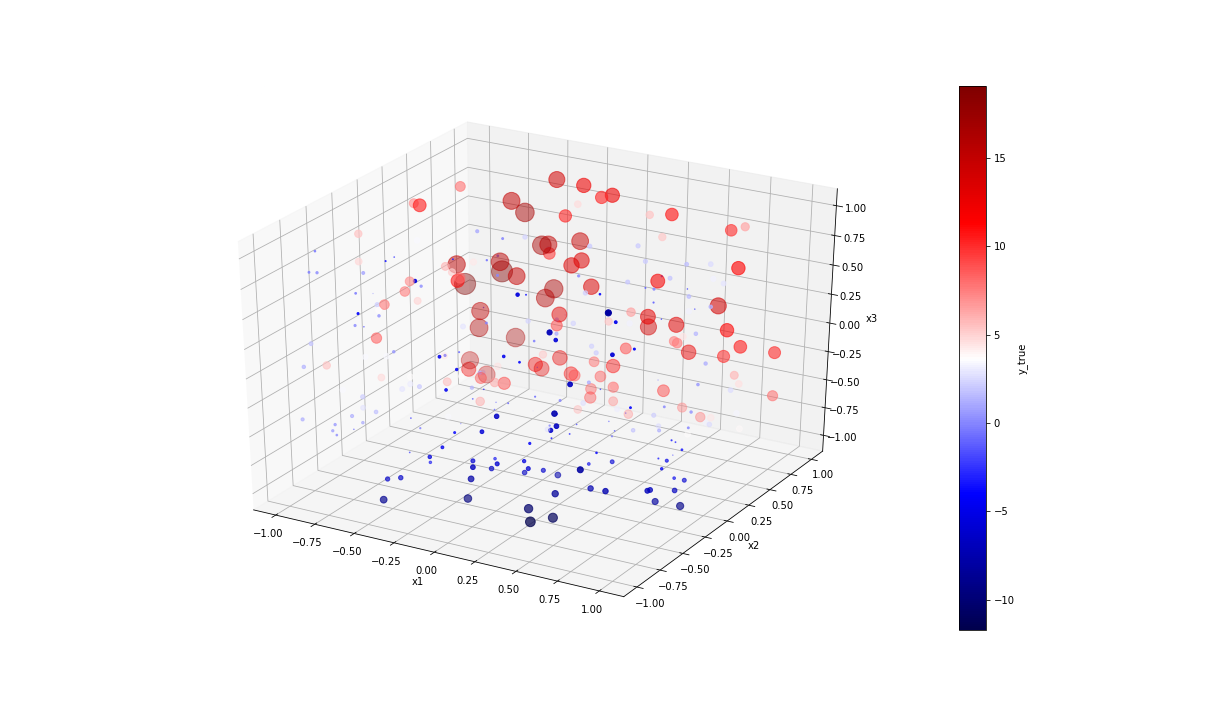

max : 19.06175422668457  min : -11.720794677734375


In [42]:
plot_4d(x[:,0], x[:,1], x[:,2], y1_pred)

<IPython.core.display.Javascript object>


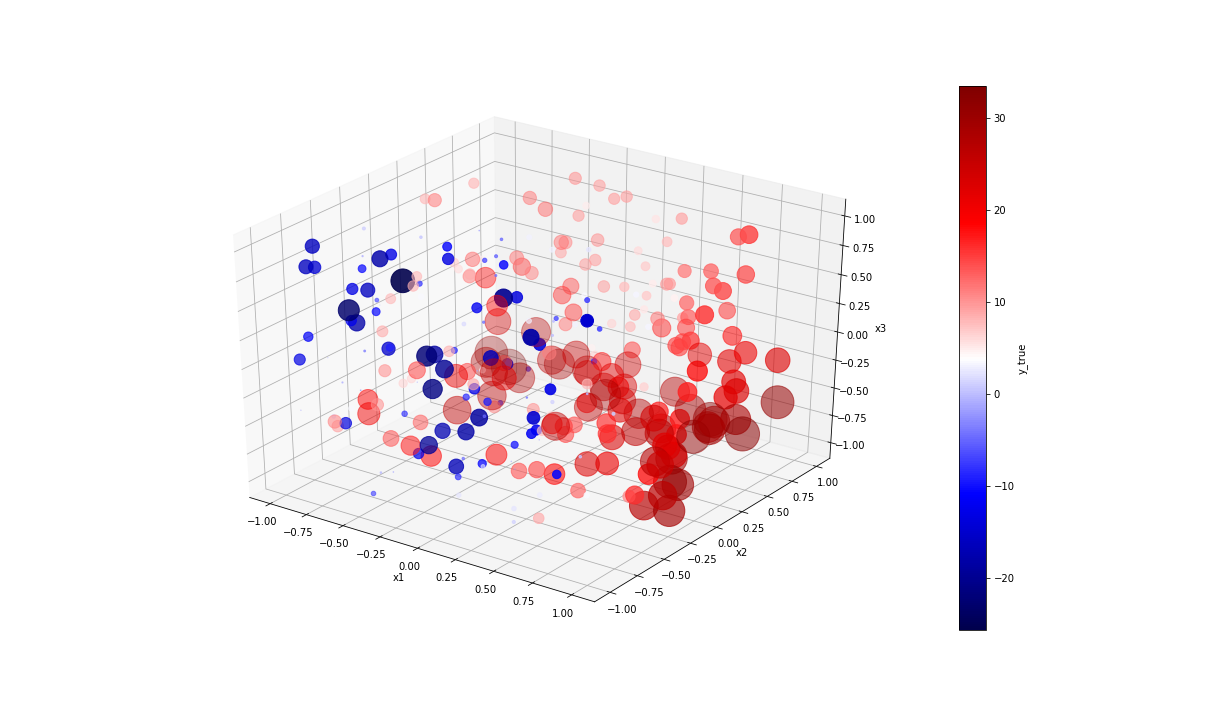

max : 33.443790435791016  min : -25.692970275878906


In [43]:
plot_4d(x[:,0], x[:,1], x[:,2], y2_pred)